In [3]:
import math, random

import gym
import numpy as np
import os
import json

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
from torch.autograd import Variable
import torch.nn.functional as F
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

<h3>Use Cuda</h3>

In [19]:
USE_CUDA = torch.cuda.is_available()
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)

<h2>Replay Buffer</h2>

In [20]:
from collections import deque

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
            
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        return len(self.buffer)

<h2>Cart Pole Environment</h2>

In [21]:
env_id = "CartPole-v0"
env = gym.make(env_id)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


<h2>Epsilon greedy exploration</h2>

In [11]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 1000

#epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

def epsilon_by_frame(frame_idx):
    val = epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)
    return val


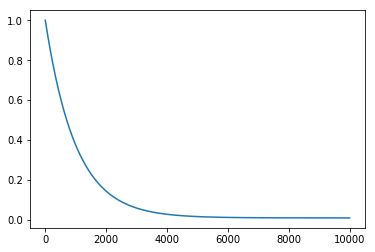

In [12]:
plt.plot([epsilon_by_frame(i) for i in range(10000)])

<h2>Double Deep Q Network</h2>

In [24]:
class DQN(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(DQN, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(env.observation_space.shape[0], 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, env.action_space.n)
        )
        
    def forward(self, x):
        return self.layers(x)
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            state   = Variable(torch.FloatTensor(state).unsqueeze(0), volatile=True)
            q_value = self.forward(state)
            action  = q_value.max(1)[1].data.item()
        else:
            action = random.randrange(env.action_space.n)
        return action

In [25]:
current_model = DQN(env.observation_space.shape[0], env.action_space.n)
target_model  = DQN(env.observation_space.shape[0], env.action_space.n)

if USE_CUDA:
    current_model = current_model.cuda()
    target_model  = target_model.cuda()
    
optimizer = optim.Adam(current_model.parameters())

replay_buffer = ReplayBuffer(1000)

<h3>Synchronize current policy net and target net</h3>

In [26]:
def update_target(current_model, target_model):
    target_model.load_state_dict(current_model.state_dict())

In [27]:
update_target(current_model, target_model)

<h2>Computing Temporal Difference Loss</h2>

In [28]:
def compute_td_loss(batch_size):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    state      = Variable(torch.FloatTensor(np.float32(state)))
    next_state = Variable(torch.FloatTensor(np.float32(next_state)))
    action     = Variable(torch.LongTensor(action))
    reward     = Variable(torch.FloatTensor(reward))
    done       = Variable(torch.FloatTensor(done))

    q_values      = current_model(state)
    next_q_values = current_model(next_state)
    next_q_state_values = target_model(next_state) 

    q_value       = q_values.gather(1, action.unsqueeze(1)).squeeze(1) 
    next_q_value = next_q_state_values.gather(1, torch.max(next_q_values, 1)[1].unsqueeze(1)).squeeze(1)
    expected_q_value = reward + gamma * next_q_value * (1 - done)
    
    loss = (q_value - Variable(expected_q_value.data)).pow(2).mean()
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss

In [29]:
def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

<h2>Training</h2>

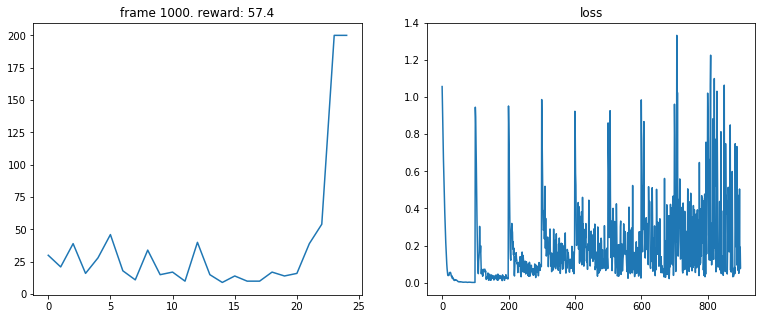

In [30]:
num_frames = 1000
batch_size = 100
gamma      = 0.99

losses = []
all_rewards = []
episode_reward = 0

# set checkpoint save directory
ckpt_dir = os.path.join('.\\checkpoints', env_id)
ckpt_paths = []
dir_exist = os.path.exists(ckpt_dir)
if (dir_exist == 0):
    os.mkdir(ckpt_dir)


state = env.reset()
for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx)
    action = current_model.act(state, epsilon)
    
    next_state, reward, done, _ = env.step(action)
    replay_buffer.push(state, action, reward, next_state, done)
    
    state = next_state
    episode_reward += reward
    
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if len(replay_buffer) > batch_size:
        loss = compute_td_loss(batch_size)
        losses.append(loss.data[0])
        
    if frame_idx % 200 == 0:
        plot(frame_idx, all_rewards, losses)
        
    if frame_idx % 100 == 0:
        update_target(current_model, target_model)
    
    # save checkpoints every so often
    if frame_idx % 200 == 0:
        ckpt_fn = 'frame_' + str(frame_idx) + '_DDQN.ckpt'
        save_dir = os.path.join(ckpt_dir, ckpt_fn)
        torch.save(current_model.state_dict(), save_dir)

        # save a list of checkpoint names for easy loading later 
        ckpt_paths.append(save_dir)

ckpt_names_fn = 'checkpoint_paths.txt'
ckpt_names_path = os.path.join(ckpt_dir, ckpt_names_fn)

with open(ckpt_names_path, 'w') as f:
    json.dump(ckpt_paths, f)


## Testing

.\checkpoints\CartPole-v0\frame_200_DDQN.ckpt


In [36]:
import gym
import random
env_id = "CartPole-v0"
env=gym.make(env_id).env
env.reset()
done=False
#env.render()
while not done:
    action = random.randrange(env.action_space.n)
    next_state,reward,done,_ = env.step(action)
    #env.render()
env.reset()
print("Action Space {}".format(env.action_space))
print("State Space {}".format(env.observation_space))
# env.render()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Action Space Discrete(2)
State Space Box(4,)


In [56]:
env_id = "CartPole-v0"
# No exploring, only playin to the model for Testing
epsilon=0
# done=False

# set checkpoint load directory
# this is after training is done and all the checkpoints are in a folder + we want to generate videos
# easily generalize by setting env_id as a variable
ckpt_names_fn = 'checkpoint_paths.txt'
ckpt_dir = os.path.join('.\\checkpoints', env_id)
ckpt_names_path = os.path.join(ckpt_dir, ckpt_names_fn)

with open(ckpt_names_path, 'r') as f:
    ckpt_paths = json.load(f)

    
vid_save_dir = os.path.join('.\\videos', env_id)
dir_exist = os.path.exists(vid_save_dir)
if (dir_exist == 0):
    os.mkdir(vid_save_dir)

def test(model, video_path):
    done=False
    model.eval()

    env_id = "CartPole-v0"
    env = gym.make(env_id).env
    env = gym.wrappers.Monitor(env, video_path, video_callable = lambda episode_idx: episode_idx%250==0)
    state = env.reset()

    #env.render()
    
    testReward=0
    while not done:
#         for frame_idx in range(1, num_frames + 1):=
#         epsilon = epsilon_by_frame(frame_idx)
        action = model.act(state, epsilon)

        next_state, reward, done, _ = env.step(action)
        #env.render()

        state = next_state
        testReward += reward
    state = env.reset()
    if done:
        env.env.close()


In [57]:
for ckpt in ckpt_paths:
    ckpt_path = ckpt
    ckpt_fn = ckpt_path.split('\\')[-1]

    video_dir = ckpt_fn[:-5]
    video_path = os.path.join('.\\videos', env_id, video_dir)
    
    dir_exist = os.path.exists(video_path)
    if (dir_exist == 0):
        os.mkdir(video_path)

    # Load the Model
    current_model = DQN(env.observation_space.shape[0], env.action_space.n).to(device)
    current_model.load_state_dict(torch.load(ckpt_path))
    
    # run the loaded model, save the output
    test(current_model, video_path)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


Exception ignored in: <bound method Monitor.__del__ of <Monitor<CartPoleEnv<CartPole-v0>>>>
Traceback (most recent call last):
  File "c:\users\jacob\appdata\local\programs\python\python36\lib\site-packages\gym\wrappers\monitor.py", line 234, in __del__
    self.close()
  File "c:\users\jacob\appdata\local\programs\python\python36\lib\site-packages\gym\wrappers\monitor.py", line 143, in close
    self.stats_recorder.close()
  File "c:\users\jacob\appdata\local\programs\python\python36\lib\site-packages\gym\wrappers\monitoring\stats_recorder.py", line 89, in close
    self.flush()
  File "c:\users\jacob\appdata\local\programs\python\python36\lib\site-packages\gym\wrappers\monitoring\stats_recorder.py", line 96, in flush
    with atomic_write.atomic_write(self.path) as f:
  File "c:\users\jacob\appdata\local\programs\python\python36\lib\contextlib.py", line 81, in __enter__
    return next(self.gen)
  File "c:\users\jacob\appdata\local\programs\python\python36\lib\site-packages\gym\utils

OSError: [WinError 6] The handle is invalid

<p><hr></p>

<h1>Atari Environment</h1>

## Training

## Testing with Visualization